## Cookie cutter TZ check

The goal of this notebook is to provide an example of how to scrape NEXRAD level II data and use pyart and csu_radar_tools to calculate radar rainfall estimates at rain gage locations during a storm. In this example we are using this 

  1. Read storm csv
  2. Find available NEXRAD data
  2. Download NEXRAD data
  4. Mask bad data
  7. Compute rainfall estimate
  9. Pull out rainfall estimates at gage locations
  9. Plot mean of gage and radar against time
  10. Change time offset to decipher which time zone gage data are in. 

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [1]:
!cat environment.yml

name: radar
channels:
- conda-forge
- defaults
dependencies:
- python=2.7
- arm_pyart
- basemap
- basemap-data-hires
- matplotlib
- jupyter
- pandas
- numpy
- cython
- wget
- lxml
- pip:
  - skewt
  - git+git://github.com/CSU-Radarmet/CSU_RadarTools.git


## Mock rain gage data

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
ID='KLWX'
latitude = 38.970
longitude = -77.473

year=2015
month=11
day=19
hour=16

t_start = '2015-11-19 16:00'
t_end = '2015-11-19 23:00'

## Find Available Data

First we will see what data are available for the date and site that we are interested in. 

In [4]:
Y = '{Y:04d}'.format(Y=year)
M = '{M:02d}'.format(M=month)
D = '{D:02d}'.format(D=day)

url = 'http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id={ID}&yyyy={Y}&mm={M}&dd={D}&product=AAL2'.format(
       ID=ID, Y=Y, M=M, D=D)

In [5]:
%%time
from lxml.html import parse

page = parse(url)
data_urls = [el.find("a").get("href") for el in page.xpath("//div[@class='bdpLink']")]
filenames = [data_url.split('/')[-1] for data_url in data_urls]
times = pd.DatetimeIndex([pd.Timestamp(fn[4:19].replace('_', ' ')) for fn in filenames])

CPU times: user 17.9 ms, sys: 6.71 ms, total: 24.6 ms
Wall time: 1.26 s


In [6]:
t0 = times.asof(pd.Timestamp(t_start))
tn = times.asof(pd.Timestamp(t_end))

data_urls = data_urls[times.get_loc(t0): times.get_loc(tn)]
filenames = filenames[times.get_loc(t0): times.get_loc(tn)]

nscans = len(filenames)

## Download Data

Now that you have a valid data_url, all that is left is downloading the data.

In [7]:
%%time

def get_datafile(data_url, filename, cache='./tmp/'):
    import os
    import wget

    if not os.path.isdir(cache):
        os.mkdir(cache)

    if os.path.isfile(cache+filename):
        print('using cached file ...')
        path_to_file = cache+filename
    else:
        print('downloading file ...')
        path_to_file = wget.download(data_url, out=cache+filename)
    print(path_to_file)
    return path_to_file

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.01 µs


In [8]:
%%time

if nscans > 100:
    print('Do you really intend to process >100 files?')
else:
    paths = []
    for data_url, filename in zip(data_urls, filenames):
        paths.append(get_datafile(data_url, filename))

downloading file ...
./tmp/KLWX20151119_155848_V06.gz
downloading file ...
./tmp/KLWX20151119_160345_V06.gz
downloading file ...
./tmp/KLWX20151119_160842_V06.gz
downloading file ...
./tmp/KLWX20151119_161339_V06.gz
downloading file ...
./tmp/KLWX20151119_161837_V06.gz
downloading file ...
./tmp/KLWX20151119_162333_V06.gz
downloading file ...
./tmp/KLWX20151119_162831_V06.gz
downloading file ...
./tmp/KLWX20151119_163328_V06.gz
downloading file ...
./tmp/KLWX20151119_163825_V06.gz
downloading file ...
./tmp/KLWX20151119_164323_V06.gz
downloading file ...
./tmp/KLWX20151119_164820_V06.gz
downloading file ...
./tmp/KLWX20151119_165317_V06.gz
downloading file ...
./tmp/KLWX20151119_165815_V06.gz
downloading file ...
./tmp/KLWX20151119_170312_V06.gz
downloading file ...
./tmp/KLWX20151119_170810_V06.gz
downloading file ...
./tmp/KLWX20151119_171334_V06.gz
downloading file ...
./tmp/KLWX20151119_171925_V06.gz
downloading file ...
./tmp/KLWX20151119_172450_V06.gz
downloading file ...
./tmp/K

## Read data and calculate rainfall

In [9]:
import pyproj
import pyart
from skewt import SkewT
from csu_radartools import csu_fhc, csu_blended_rain, csu_dsd, csu_kdp

In [10]:
gage_df = pd.read_csv('./storm_gage.csv', index_col=0)

gage_names = gage_df.index

mean_gage = gage_df.iloc[:, 2:].mean(axis=0)
mean_gage.index = mean_gage.index.to_datetime()
mean_gage.name = 'gage'

## Run
First you need to run all the functions in the [last cell](#Functions), then you can process all the radar files

In [13]:
%%time
radar0 = pyart.io.read(paths[0])
netcdf=False
gage_dict={}
for gage_name in gage_names:
    if netcdf:
        latitude = ds_gage.lat.sel(station=gage_name).values
        longitude = ds_gage.lon.sel(station=gage_name).values
    else:
        latitude = gage_df.loc[gage_name, 'lat']
        longitude = gage_df.loc[gage_name, 'lon']
    x_disp, y_disp = find_x_y_displacement(radar0, longitude, latitude)
    gage_dict.update({gage_name: {'x_disp': x_disp, 'y_disp': y_disp}})

CPU times: user 1.32 s, sys: 464 ms, total: 1.78 s
Wall time: 4.12 s


In [14]:
fields = ['r_z']
cols = ['gate_lon', 'gate_lat', 'gate_altitude']
cols.extend(fields)

In [15]:
sweep_times = []
sweep_stacks = []
for path in paths:
    print('processing', path)
    radar = process_radar(path)
    base_time = pd.Timestamp(radar.time['units'].split()[2])
    for sweep in range(radar.nsweeps):
        end_sweep_time = pd.Timedelta(seconds=radar.time['data'][radar.get_end(sweep)])+base_time
        gate_x, gate_y, gate_z = radar.get_gate_x_y_z(sweep)
        sweep_times.append(end_sweep_time)
        
        b = []
        for gage_name in gage_names:
            distances = np.sqrt((gate_x-gage_dict[gage_name]['x_disp'])**2. + 
                                (gate_y-gage_dict[gage_name]['y_disp'])**2.)
            ray, gate = np.unravel_index(distances.argmin(), distances.shape)

            a = np.array([radar.gate_latitude['data'][ray, gate],
                          radar.gate_longitude['data'][ray, gate],
                          radar.gate_altitude['data'][ray, gate]])
            a = np.concatenate([a, [radar.fields[field]['data'][ray, gate] for field in fields]])
            b.append(a)
        sweep_stacks.append(np.stack(b, axis=1))
c = np.stack(sweep_stacks, axis=2)

d = {'time': {'dims': ('time'), 'data': sweep_times},
     'station': {'dims': ('station'), 'data': gage_names}}

for i, name in enumerate(cols):
    d.update({name: {'dims': ('station', 'time'), 'data': c[i]}})
ds_radar = xr.Dataset.from_dict(d)
ds_radar.set_coords(['gate_altitude', 'gate_lat', 'gate_lon'], inplace=True)

('processing', './tmp/KLWX20151119_155848_V06.gz')


/home/jsignell/miniconda2/envs/radar/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


('processing', './tmp/KLWX20151119_160345_V06.gz')
('processing', './tmp/KLWX20151119_160842_V06.gz')
('processing', './tmp/KLWX20151119_161339_V06.gz')
('processing', './tmp/KLWX20151119_161837_V06.gz')
('processing', './tmp/KLWX20151119_162333_V06.gz')
('processing', './tmp/KLWX20151119_162831_V06.gz')
('processing', './tmp/KLWX20151119_163328_V06.gz')
('processing', './tmp/KLWX20151119_163825_V06.gz')
('processing', './tmp/KLWX20151119_164323_V06.gz')
('processing', './tmp/KLWX20151119_164820_V06.gz')
('processing', './tmp/KLWX20151119_165317_V06.gz')
('processing', './tmp/KLWX20151119_165815_V06.gz')
('processing', './tmp/KLWX20151119_170312_V06.gz')
('processing', './tmp/KLWX20151119_170810_V06.gz')
('processing', './tmp/KLWX20151119_171334_V06.gz')
('processing', './tmp/KLWX20151119_171925_V06.gz')
('processing', './tmp/KLWX20151119_172450_V06.gz')
('processing', './tmp/KLWX20151119_173041_V06.gz')
('processing', './tmp/KLWX20151119_173634_V06.gz')
('processing', './tmp/KLWX20151

<xarray.Dataset>
Dimensions:        (station: 46, time: 79)
Coordinates:
  * station        (station) object 'BC21' 'BC22' 'BC23' 'BC24' 'BC25' ...
  * time           (time) datetime64[ns] 2015-11-19T15:59:19.805000 ...
    gate_altitude  (station, time) float64 1.421e+03 1.421e+03 1.421e+03 ...
    gate_lat       (station, time) float64 -76.51 -76.51 -76.51 -76.51 ...
    gate_lon       (station, time) float64 39.24 39.24 39.24 39.24 39.24 ...
Data variables:
    r_z            (station, time) float64 0.8113 0.03565 nan 0.02786 nan ...

In [16]:
%%time
ds_radar_5 = ds_radar[fields].resample('5min', 'time', label='right')

CPU times: user 54.6 ms, sys: 3.18 ms, total: 57.8 ms
Wall time: 447 ms


In [17]:
radar_df = ds_radar_5.r_z.mean('station').to_dataframe()

## Different time zone options:
[UTC](#UTC) | [US/Eastern](#US/Eastern) | [EST](#EST)

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

### UTC

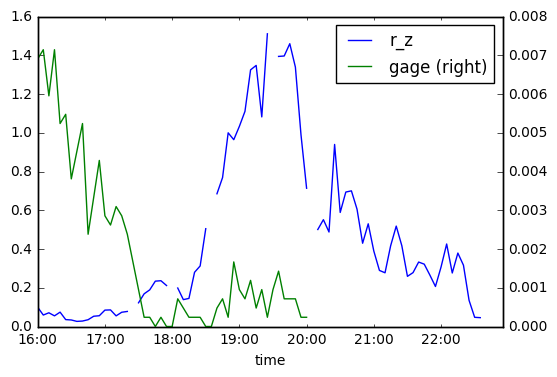

In [25]:
radar_df.join(mean_gage).plot(secondary_y='gage')
plt.savefig('tmp/UTC_{storm}.png'.format(storm=t_start[:10]))

### US/Eastern

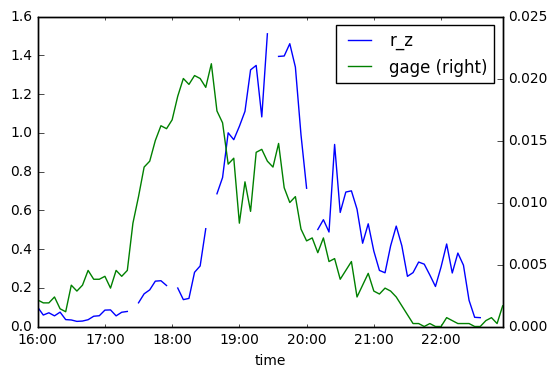

In [26]:
mean_gage.index+=pd.Timedelta(hours=4)
radar_df.join(mean_gage).plot(secondary_y='gage')
mean_gage.index-=pd.Timedelta(hours=4)
plt.savefig('tmp/US_Eastern_{storm}.png'.format(storm=t_start[:10]))

### EST

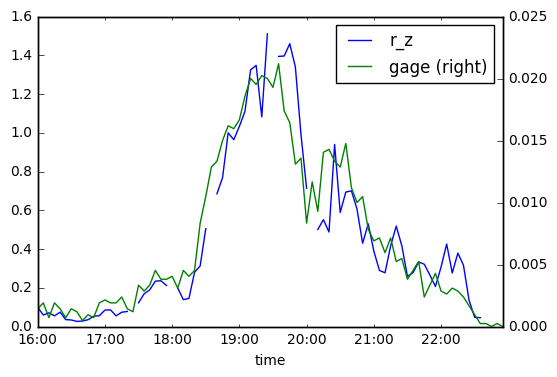

In [27]:
mean_gage.index+=pd.Timedelta(hours=5)
radar_df.join(mean_gage).plot(secondary_y='gage')
mean_gage.index-=pd.Timedelta(hours=5)
plt.savefig('tmp/EST_{storm}.png'.format(storm=t_start[:10]))

Clean up and remove cached radar files

In [28]:
!rm tmp/K*

## Functions
Run the cell below, then [hop back up](#Run) and process all the files.

In [12]:
def process_radar(path):
    radar = pyart.io.read(path)
    radar, start_gate, end_gate = mask_data(radar)
    radar, vel_radar = separate_dp_vel_sweeps(radar)
    calculate_rainfall(radar, start_gate, end_gate)
    return radar

def mask_data(radar, max_elevation_angle=0.6, min_dist_km=5, max_dist_km=300):
    # We just want the lowest sweeps and the gates at which we can reasonably have good data
    low_sweeps = [i for i, bool in enumerate(radar.fixed_angle['data']<max_elevation_angle) if bool]
    radar = radar.extract_sweeps(low_sweeps)

    if radar.range['units'] == 'meters':
        start_gate = (radar.range['data']< min_dist_km*1000).sum()
        end_gate = (radar.range['data']< max_dist_km*1000).sum()

    for field in radar.fields.keys():
        radar.fields[field]['data'].mask[:,:start_gate] = True
    return radar, start_gate, end_gate

def separate_dp_vel_sweeps(radar):
    # check that adjoining times are close?
    dp_sweeps = [i for i in range(radar.nsweeps) if ~radar.extract_sweeps([i]).fields['differential_phase']['data'].mask.all()]
    vel_sweeps = [i for i in range(radar.nsweeps) if ~radar.extract_sweeps([i]).fields['velocity']['data'].mask.all()]

    vel_radar = radar.extract_sweeps(vel_sweeps)
    dp_radar = radar.extract_sweeps(dp_sweeps)
    
    return dp_radar, vel_radar

def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def calculate_rainfall(radar, start_gate, end_gate):
    dz = extract_unmasked_data(radar, 'reflectivity')
    r_z = csu_blended_rain.calc_rain_nexrad(dz)
    radar = add_field_to_radar_object(r_z, radar, field_name='r_z', units='mm h-1',
                                      long_name='Rainfall Rate R(Z)', 
                                      standard_name='Rainfall Rate')
    return radar

def find_x_y_displacement(radar, longitude, latitude):
    """ Return the x and y displacement (in meters) from a radar location. """
    # longitude and latitude in degrees
    lat_0 = radar.latitude['data'][0]
    lon_0 = radar.longitude['data'][0]
    proj = pyproj.Proj(proj='aeqd', lon_0=lon_0, lat_0=lat_0)
    return proj(longitude, latitude)

[hop back up](#Run) and process all the files.